In [1]:
import numpy as np
import json
from collections import Counter
from matplotlib import pyplot as plt
import os
import pickle

In [2]:
def counter_to_array(counter, n_classes=10):
    array = np.zeros(n_classes, dtype=np.int64)
    for key, value in counter.items():
        array[key] += value
    return array

In [3]:
TASK = 'synthetic_classification_cnum6_dist11_skew1.0_seed0'

In [4]:
with open('/mnt/disk1/duongtn/ShapleyFL/fedtask/{}/data.json'.format(TASK), 'r') as f:
    data= json.load(f)

In [5]:
data.keys()

dict_keys(['store', 'client_names', 'dtest', 'Client0', 'Client1', 'Client2', 'Client3', 'Client4', 'Client5'])

In [6]:
data['client_names']

['Client0', 'Client1', 'Client2', 'Client3', 'Client4', 'Client5']

In [7]:
print('test', len(data['dtest']['y']))
for client in data['client_names']:
    print(client, len(data[client]['dtrain']['y']), len(data[client]['dvalid']['y']))

test 602
Client0 1836 367
Client1 918 183
Client2 612 122
Client3 459 91
Client4 366 74
Client5 306 61


In [8]:
counter = Counter(data['dtest']['y'])
print('test', counter_to_array(counter))
for client in data['client_names']:
    counter = Counter(data[client]['dtrain']['y'])
    print(client, counter_to_array(counter))

test [ 45   6 116  47  94  23  26  91 153   1]
Client0 [142  24 308 115 321  54  68 344 459   1]
Client1 [ 76  15 133  65 175  23  49 157 225   0]
Client2 [ 44   8  94  39 116  16  22 100 173   0]
Client3 [ 30   8  72  29  86  14  18  81 121   0]
Client4 [31  8 61 19 62 13 15 67 89  1]
Client5 [22  5 44 33 59  7 10 46 80  0]


In [9]:
train_len = np.array([len(data[client]['dtrain']['y']) for client in data['client_names']])
train_len_p = train_len / train_len.sum()
train_len_p

array([0.40827218, 0.20413609, 0.13609073, 0.10206805, 0.08138759,
       0.06804536])

In [10]:
train_len.sum()

4497

In [11]:
folder = 'fedtask/{}/record/'.format(TASK)
prefix = 'fedavg_Mlr_R100_B10.0_E2_LR0.5000_P1.00_S0_LD1.000_WD0.000_AVLIDL_CNIDL_CPIDL_TIDL_'
DICT = dict()
files = os.listdir(folder)
files.sort(reverse=True)
for file in files:
    if file.startswith(prefix):
        with open(os.path.join(folder, file), 'r') as f:
            DICT[file.replace(prefix, '').replace('.json', '')] = np.array(json.load(f)['test_accuracy'])
DICT['0' * len(data['client_names'])] = np.zeros(101)

In [12]:
# plt.figure(figsize=(15, 10))
# for key, value in DICT.items():
#     plt.plot(value[:], label=key)
# plt.legend()
# plt.show()

In [13]:
from bitsets import bitset
import itertools

In [14]:
CLIENTS_BITSET = bitset('clients_bitset', tuple(data['client_names']))

In [15]:
SV = dict()
for client in data['client_names']:
    result = 0.0
    rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
    for i in range(0, len(rest_clients) + 1):
        a_i = 0.0
        count_i = 0
        for subset in itertools.combinations(rest_clients, i):
            # print(subset)
            a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max()
            if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                    print(client, subset)
            # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
            count_i += 1
        # print(a_i, count_i)
        a_i = a_i / count_i
        result += a_i
    result = result / len(data['client_names'])
    SV[client] = result

In [16]:
sv = np.array(list(SV.values()))
sv = sv / sv.sum()
sv

array([0.2245045 , 0.17840841, 0.15465465, 0.14936937, 0.15099099,
       0.14207207])

In [17]:
sum(SV.values())

0.9219269102990035

In [18]:
accuracy = dict()
exact = dict()
const_lambda = list()
optimal_lambda = dict()
for round_ in range(1, 101):
    # with open('SV_result/{}/min_max/minRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     min_v = pickle.load(f)
    min_v = 0.0
    # with open('SV_result/{}/min_max/maxRound{}.npy'.format(TASK, round_), 'rb') as f:
    #     max_v = pickle.load(f)
    max_v = 1.0
    for u in [1, 2, 3, 4, 5, 6]:
        if u not in accuracy.keys(): accuracy[u] = list()
        if u not in exact.keys(): exact[u] = list()
        with open('SV_result/{}/client_accuracy-{}/Round{}.npy'.format(TASK, u, round_), 'rb') as f:
            accuracy[u].append((pickle.load(f) / (max_v - min_v)).tolist())
        with open('SV_result/{}/exact-{}/Round{}.npy'.format(TASK, u, round_), 'rb') as f:
            exact[u].append((pickle.load(f) / (max_v - min_v)).tolist())
    with open('SV_result/{}/const_lambda/Round{}.npy'.format(TASK, round_), 'rb') as f:
        const_lambda.append((pickle.load(f) / (max_v - min_v)).tolist())
    for ns in [30, 40, 50, 60, 63]:
        if ns not in optimal_lambda.keys():
            optimal_lambda[ns] = list()
        with open('SV_result/{}/optimal_lambda-{}/Round{}.npy'.format(TASK, ns, round_), 'rb') as f:
            optimal_lambda[ns].append((pickle.load(f) / (max_v - min_v)).tolist())
const_lambda = np.array(const_lambda)
for key in exact.keys():
    exact[key] = np.array(exact[key])
for key in accuracy.keys():
    accuracy[key] = np.array(accuracy[key])
for key in optimal_lambda.keys():
    optimal_lambda[key] = np.array(optimal_lambda[key])
# *[e.shape for opt in exact.values()], const_lambda.shape, *[opt.shape for opt in optimal_lambda.values()]

In [19]:
# fig, ax = plt.subplots(nrows=2, ncols=4)
# fig.set_figheight(18)
# fig.set_figwidth(32)
# ax[0, 0].set_title('Exact')
# ax[0, 0].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], exact):
#     ax[0, 0].plot(clients_sv[:], label=client)
# ax[0, 1].set_title('Const lambda')
# ax[0, 1].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], const_lambda):
#     ax[0, 1].plot(clients_sv[:], label=client)
# ax[0, 2].set_title('Optimal lambda 30')
# ax[0, 2].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], optimal_lambda[30]):
#     ax[0, 2].plot(clients_sv[:], label=client)
# ax[0, 3].set_title('Optimal lambda 40')
# ax[0, 3].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], optimal_lambda[40]):
#     ax[0, 3].plot(clients_sv[:], label=client)
# ax[1, 0].set_title('Optimal lambda 50')
# ax[1, 0].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], optimal_lambda[50]):
#     ax[1, 0].plot(clients_sv[:], label=client)
# ax[1, 1].set_title('Optimal lambda 60')
# ax[1, 1].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], optimal_lambda[60]):
#     ax[1, 1].plot(clients_sv[:], label=client)
# ax[1, 2].set_title('Optimal lambda 63')
# ax[1, 2].set_ylim((0, 0.4))
# for client, clients_sv in zip(data['client_names'], optimal_lambda[63]):
#     ax[1, 2].plot(clients_sv[:], label=client)
# for client, clients_sv in zip(data['client_names'], optimal_lambda[63]):
#     ax[1, 3].plot(clients_sv[:0], label=client)
# ax[1, 3].legend(loc='center', fontsize=20)
# plt.show()

In [20]:
def minmax_scale(values):
    result = list()
    for value in values:
        result.append(((value - value.min()) / (value.max() - value.min())).tolist())
    return np.array(result)

In [21]:
def aggregate(values, exp=None, alpha=None):
    result = np.zeros(values.shape[1])
    if alpha is None:
        if exp is None:
            result = values.sum(axis=0)
        else:
            for i, value in enumerate(values):
                result += value / pow(i + 1, exp)
    else:
        for i, value in enumerate(values):
            result += value * pow(alpha, i)
    # if result.min() < 0.0:
    #     result = result - result.min()
    result = result / result.sum()
    return result

In [22]:
# corrs = list()
# for alpha in np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01):
#     e = aggregate(exact, alpha=alpha)
#     corrs.append(np.corrcoef(e, sv)[0, 1])
# corrs = np.array(corrs)
# np.arange(start=0.0, stop=1.0 + 1e-6, step=0.01)[corrs.argmax()]

In [23]:
# corrs = list()
# for exp in np.arange(start=0, stop=10 + 1e-6, step=0.1):
#     e = aggregate(exact, exp=exp)
#     corrs.append(np.corrcoef(e, sv)[0, 1])
# corrs = np.array(corrs)
# np.arange(start=0, stop=10 + 1e-6, step=0.1)[corrs.argmax()]

In [24]:
# corrs = list()
# for round_ in np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int):
#     e = aggregate(exact[:round_])
#     corrs.append(np.corrcoef(e, sv)[0, 1])
# corrs = np.array(corrs)
# np.arange(start=1, stop=100 + 1e-6, step=1, dtype=int)[corrs.argmax()]

In [25]:
def get_comm_round(_exact):
    check = np.array([False] * len(data['client_names']))
    for i, e in enumerate(_exact):
        check[np.where(e > 0.0)[0]] = True
        if np.all(check): return i
    return _exact.shape[0]

In [26]:
for u in [1, 2, 3, 4, 5, 6]:
    print(u, get_comm_round(exact[u]))

1 23
2 3
3 3
4 2
5 1
6 0


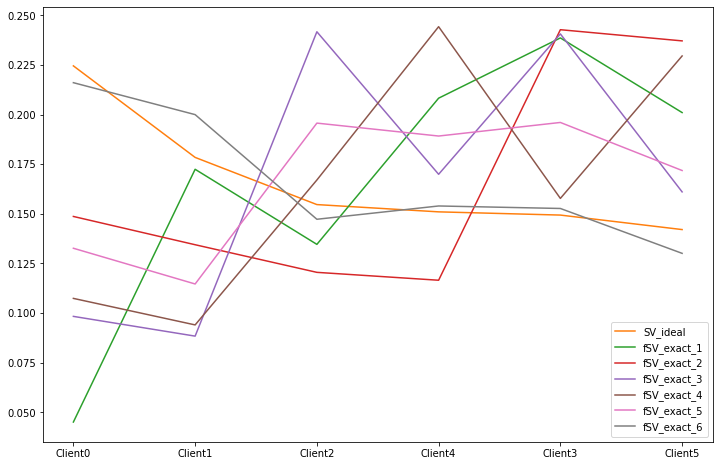

In [27]:
plt.figure(figsize=(12, 8))
# plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:blue')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[1][:get_comm_round(exact[1]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_1', color='tab:green')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[2][:get_comm_round(exact[2]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_2', color='tab:red')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[3][:get_comm_round(exact[3]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_3', color='tab:purple')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[4][:get_comm_round(exact[4]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_4', color='tab:brown')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[5][:get_comm_round(exact[5]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_5', color='tab:pink')
plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], aggregate(exact[6][:get_comm_round(exact[6]) + 1])[np.argsort(sv)[::-1]], label='fSV_exact_6', color='tab:gray')
plt.legend()
plt.show()

In [28]:

# for i, e in enumerate(exact[:]):
#     plt.figure(figsize=(8, 6))
#     plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], train_len_p[np.argsort(sv)[::-1]], label='data', color='tab:gray')
#     plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]], sv[np.argsort(sv)[::-1]], label='SV_ideal', color='tab:orange')
#     plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
#              aggregate(minmax_scale(np.expand_dims(e, axis=0)))[np.argsort(sv)[::-1]], label='MinMaxScale Round {}'.format(i))
#     plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
#              aggregate(minmax_scale(np.expand_dims(accuracy[i], axis=0)))[np.argsort(sv)[::-1]], label='Accuracy', color='tab:purple')
#     plt.plot(np.array(data['client_names'])[np.argsort(sv)[::-1]],
#              aggregate(np.expand_dims(e, axis=0))[np.argsort(sv)[::-1]], label='Round {}'.format(i), color='tab:red')
#     plt.legend()
#     plt.show()

In [34]:
DICT['111100'][:101].shape

(101,)

In [35]:
SV = dict()
for round_ in range(1, 101):
    SV[round_] = dict()
    for client in data['client_names']:
        result = 0.0
        rest_clients = [client_ for client_ in data['client_names'] if client_ != client]
        for i in range(0, len(rest_clients) + 1):
            a_i = 0.0
            count_i = 0
            for subset in itertools.combinations(rest_clients, i):
                # print(subset)
                a_i += DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][:round_ + 1].max() - \
                    DICT[CLIENTS_BITSET(subset).bits()][:round_ + 1].max()
                # if DICT[CLIENTS_BITSET(set(subset).union({client})).bits()].max() - \
                #     DICT[CLIENTS_BITSET(subset).bits()].max() < 0:
                #         print(client, subset)
                # print(DICT[CLIENTS_BITSET(set(subset).union({client})).bits()][-1], DICT[CLIENTS_BITSET(subset).bits()][-1])
                count_i += 1
            # print(a_i, count_i)
            a_i = a_i / count_i
            result += a_i
        result = result / len(data['client_names'])
        SV[round_][client] = result

In [42]:
SV_NORM = dict()
for round_ in range(1, 101):
    sv = list()
    for client in data['client_names']:
        sv.append(SV[round_][client])
    sv = np.array(sv)
    sv = sv / sv.sum()
    SV_NORM[round_] = sv

In [49]:
CORR = list()
for i in range(1, 101):
    CORR.append(np.corrcoef(SV_NORM[i], SV_NORM[100])[0, 1])
CORR = np.array(CORR)

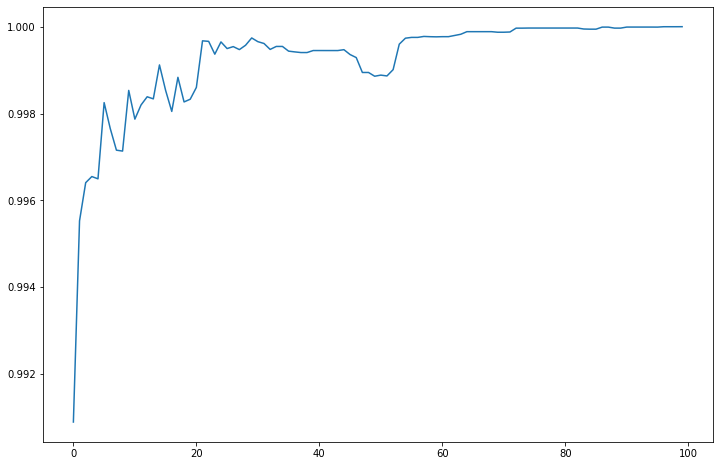

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(CORR)
plt.show()

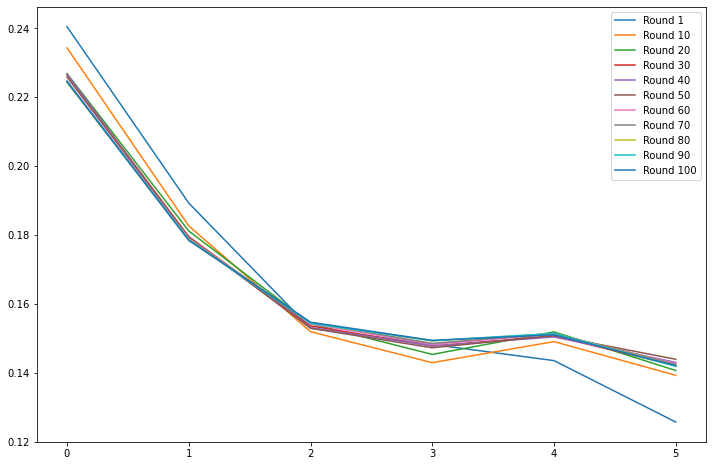

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(SV_NORM[1], label='Round {}'.format(1))
for round__ in range(1, 11):
    round_ = 10 * round__
    plt.plot(SV_NORM[round_], label='Round {}'.format(round_))
plt.legend()
plt.show()